In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# INTRODUCTION
이동수단 유형 별 라벨링 후 데이터 셋을 통합한다. 통합된 데이터 셋을 통해 공통된 토픽을 생성하고 토픽별 문서 별 할당량을 통해 어떤 유형이 토픽이 많은지 유추한다.

# 환경 설정
hSBM topic model을 위한 환경 설정

## graph-tool
graph-tool을 위한 각종 apk-get process

In [2]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.93jNSm3vas/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://downloads.skewed.de/apt jammy/main amd64 Packages [2,989 B]
Get:10 http://archive.ubuntu.com/ubuntu 

In [3]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 39 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 129246 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libg

In [4]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 47.9 MB/s eta 0:00:00


## git clone
hSBM_Topicmodel git clone

In [5]:
!git clone https://github.com/martingerlach/hSBM_Topicmodel.git

Cloning into 'hSBM_Topicmodel'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 399 (delta 57), reused 34 (delta 34), pack-reused 321
Receiving objects: 100% (399/399), 25.38 MiB | 26.23 MiB/s, done.
Resolving deltas: 100% (126/126), done.


## import 및 객체생성

In [6]:
import sys
sys.path.append('/content/hSBM_Topicmodel')

In [7]:
import pandas as pd
from random import choice
import scipy.stats
import sys
import graph_tool.all as gt
import pandas as pd
import numpy as np
import os
import time

from sbmtm import sbmtm
import pylab as plt

import re
from konlpy.tag import Okt
from collections import Counter

In [8]:
okt = Okt()

In [9]:
model = sbmtm() # 모델 인스턴스 생성

In [10]:
os.environ['JAVA_OPTS'] = 'Xmx4096M'

# Data preprocessing

In [11]:
df_train = pd.read_csv('/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /기차여행_통합_6835.csv')
df_bus = pd.read_csv('/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /버스여행_통합_6828.csv')
df_air = pd.read_csv('/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /비행기여행_통합_5747.csv')
df_car = pd.read_csv('/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /자동차여행_통합_5757.csv')
df_bike = pd.read_csv('/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /자전거여행/자전거여행_통합_7271.csv')

print(df_train.shape)
print(df_bus.shape)
print(df_air.shape)
print(df_car.shape)
print(df_bike.shape)

(6835, 6)
(6828, 6)
(5747, 6)
(5757, 6)
(7271, 6)


## data labeling & Merge

In [12]:
df_train['label'] = 1
df_bus['label'] = 2
df_air['label'] = 3
df_car['label'] = 4
df_bike['label'] = 5

In [13]:
df = pd.concat([df_train, df_bus, df_air, df_car, df_bike])

df

,post_dates,title,url,full_text,year,month,label
0,2022-01-01,"7살 아이와 기차여행, KTX 타고 강릉 1박2일 맛집 및 숙소 후기",https://blog.naver.com/jungae0104/222618341297,[' 7살 아이와 기차여행 KTX타고 강릉 1박2일 맛집 및 숙소 후기 왕년 주말부...,2022,1,1
1,2022-01-01,떠나자 2박3일 경주 /겨울 기차여행 /경주여행,https://blog.naver.com/fosa_/222625670856,[' 비몽사몽 새벽 기차 여행 시작 근데 택시에 모자 두고 내려서 다시 구하러 갔...,2022,1,1
2,2022-01-01,대구 기차여행,https://blog.naver.com/maeng_s_love/222623428297,"[' 주루와 함께 떠난 당일치기 대구 기차여행 사실, 안주먹으면서 군대 휴가 이...",2022,1,1
3,2022-01-01,국내 기차 여행 여수 엑스포역 KTX 시간표,https://blog.naver.com/obh1680/222622923479,[' 국내 기차 여행 여수 엑스포역 KTX 시간표 안녕하세요 여행 인플루언서 혀니...,2022,1,1
4,2022-01-01,(강릉커플여행_#1) 진짜 간만에 기차여행! 청량리에서...,https://blog.naver.com/lucidbreeze7/222631822201,[' 반갑습니다 오랜만이네요 하 그간 이래저래 바빴네요 지난 주말에는 진짜 첨으로...,2022,1,1
...,...,...,...,...,...,...,...
7266,2023-09-01,안민도로 구경 여러분들께 알려드려요,https://blog.naver.com/smoothoqw273/223203470951,[' 안민도로 구경 여러분들께 알려드려요 안민도로 구경 자세하게 알아봤어요 안민...,2023,9,5
7267,2023-09-01,편두통 원인 분노 등이 원인입니다.,https://blog.naver.com/advendture5526/22320016...,[' 또한 카페인을 계속적으로 섭취하도록 앞으로는 편두통 완화 방법에 대해 알아봤어...,2023,9,5
7268,2023-09-01,충청도 구경 자세히 알아봅시다,https://blog.naver.com/greywwj666/223206012791,[' 충청도 구경 자세히 알아봅시다 충청도 구경 유익한 내용 충청도는 대한민국의...,2023,9,5
7269,2023-09-01,가장 멋진 여행지를 찾아 떠나보는 이야기,https://blog.naver.com/g618mi2xc/223202707470,[' 가장 멋진 여행지를 찾아 떠나보는 이야기 나는 가장 멋진 여행지를 찾아 떠나는...,2023,9,5


In [14]:
def process_dataframe(df):

    # "full_text" 열에 10글자 이하인 문자열을 null로 바꾸기
    df.loc[df['full_text'].str.len() <= 10, 'full_text'] = None

    # "full_text" 열에 빈칸(' ')으로만 구성된 문자열을 null로 바꾸기
    df.loc[df['full_text'].str.strip() == '', 'full_text'] = None

    # null인 행 제거
    df = df.dropna(subset=['full_text'])

    # "year" 열이 2022이고 "month" 열이 1, 2, 3 중 하나인 행 제거
    condition1 = (df['year'] == 2022) & (df['month'].isin([1, 2, 3]))

    # 필터링 조건을 만족하는 행을 제외하고 새로운 데이터프레임을 반환
    filtered_df = df[~condition1]

    # "full_text" 열에 특수 문자 및 숫자 제거 함수 적용
    filtered_df['full_text'] = filtered_df['full_text'].apply(lambda text: re.sub(r'[^a-zA-Z가-힣\s]', '', text))

    # 인덱스 초기화
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

In [15]:
df_train = process_dataframe(df)

display(df_train.head())
print(df_train.shape)

<ipython-input-14-f49d8aed291f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_text'] = filtered_df['full_text'].apply(lambda text: re.sub(r'[^a-zA-Z가-힣\s]', '', text))


,post_dates,title,url,full_text,year,month,label
0,2022-04-01,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출,https://blog.naver.com/maum0577/222693452588,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출 여수 뚜벅이 여행으로 기...,2022,4,1
1,2022-04-01,KTX 유아동반석 : 아이랑 기차여행 1박2일 정동진 여행 ♬,https://blog.naver.com/kiki9175/222698429937,KTX 유아동반석 아이랑 기차여행 드디어 첫기차여행 두둥 세 세 반짝별남매와...,2022,4,1
2,2022-04-01,"강릉 기차여행 도착, 출발지 강릉역 KTX",https://blog.naver.com/kyena200/222683013749,강릉 기차여행 도착 출발지 강릉역 KTX 글 사진 쏠트몬 요즘 종종 기차여행...,2022,4,1
3,2022-04-01,아이랑 둘이 춘천 당일치기 기차여행,https://blog.naver.com/dmsthf9075/222703959538,안녕하세요 앨리스맘블로그에요 요즘 날씨가 더웠다 추웠다 난리라 코로나도 그...,2022,4,1
4,2022-04-01,"편안한 기차여행, KTX-이음 노선과 일반실 살펴보기",https://blog.naver.com/korailblog/222712386908,KTX이음 서울행신강릉 서울동해 청량리안동 부발충주 구간 운행 중 휴대폰 무선 ...,2022,4,1


(28117, 7)


## 특정 키워드 행 제거
스플로그 블로그 데이터를 제거하기 위한 process

In [16]:
def remove_rows_with_keywords(df, keywords):
    for keyword in keywords:
        df = df[~df['full_text'].str.contains(keyword)]
    return df

In [17]:
keywords_to_remove = ['결혼식', '장난감','그림책','그림','지리','어린이집','세계사','드라마','악기','독서','소설',
                      '글쓰기','필사','동물''저자','기후변화','베이스볼','윙스토랑','영화','제작','증상','치료','그림책','CD숍','시인','소설','베스트셀러'
                      ]

In [18]:
df_train = remove_rows_with_keywords(df_train, keywords_to_remove)

In [19]:
display(df_train.head())
print(df_train.shape)

,post_dates,title,url,full_text,year,month,label
0,2022-04-01,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출,https://blog.naver.com/maum0577/222693452588,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출 여수 뚜벅이 여행으로 기...,2022,4,1
2,2022-04-01,"강릉 기차여행 도착, 출발지 강릉역 KTX",https://blog.naver.com/kyena200/222683013749,강릉 기차여행 도착 출발지 강릉역 KTX 글 사진 쏠트몬 요즘 종종 기차여행...,2022,4,1
3,2022-04-01,아이랑 둘이 춘천 당일치기 기차여행,https://blog.naver.com/dmsthf9075/222703959538,안녕하세요 앨리스맘블로그에요 요즘 날씨가 더웠다 추웠다 난리라 코로나도 그...,2022,4,1
4,2022-04-01,"편안한 기차여행, KTX-이음 노선과 일반실 살펴보기",https://blog.naver.com/korailblog/222712386908,KTX이음 서울행신강릉 서울동해 청량리안동 부발충주 구간 운행 중 휴대폰 무선 ...,2022,4,1
5,2022-04-01,"기차 멍 때리기, 수서↔부산 SRT 기차여행",https://blog.naver.com/jenny_on/222694738116,코로나로 기차보다는 주로 차량으로 이동하다가 오랫만에 수서역에서 SRT타고 부산을...,2022,4,1


(20437, 7)


## Stopword 정의
korean_stopword와 미리 정의한 stopword 를 정의함

In [20]:
korean_stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

In [21]:
excel_paths = [
    '/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /stopword_이동수단.xlsx',
    '/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /stopword_이동수단_버스.xlsx',
    '/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /stopword_이동수단_비행기.xlsx',
    '/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /stopword_이동수단_자동차.xlsx',
    '/content/drive/MyDrive/OTA 후속연구/Data_Set/raw_data/이동 수단 별 여행객 /stopword_이동수단_자전거.xlsx.xlsx'
]

In [22]:
df_list = [pd.read_excel(path) for path in excel_paths]
combined_df = pd.concat(df_list, ignore_index=True)

# Drop duplicates to get a unique list of stop words
unique_stop_words = combined_df.drop_duplicates()

# If your stop words are in a specific column, e.g., 'stop_word', do this:
# unique_stop_words = combined_df['stop_word'].drop_duplicates()

# Define the stop words list
stop_word = unique_stop_words

In [23]:
col = 'stopword'
words_column = stop_word[col]
user_specific_stopwords = list(words_column.dropna().unique())

print(user_specific_stopwords)

['여행', '타고', '우리', '정도', '바로', '정말', '다시', '하나', '여기', '진짜', '다음', '오늘', '때문', '시작', '보고', '이번', '다른', '조금', '처음', '그냥', '위해', '가장', '이제', '지금', '한번', '가지', '근처', '마지막', '사실', '미리', '아주', '모두', '역시', '사용', '확인', '동안', '가기', '저희', '계속', '출처', '경우', '거의', '중간', '내일', '아래', '어디', '여유', '가게', '먼저', '가면', '통해', '참고', '보기', '제일', '요즘', '호차', '잠시', '사이', '중앙', '이상', '일단', '모든', '일반', '일차', '박일', '최고', '라면', '더욱', '오후', '직접', '기도', '또한', '고민', '마치', '일찍', '원래', '여러', '수도', '별로', '대한', '가능', '오전', '진행', '예전', '순간', '뭔가', '완전', '살짝', '유매우', '갑자기', '인생', '가야', '대해', '기준', '이후', '마무리', '자주', '종류', '덕분', '간다', '소요', '필수', '나라', '약간', '나름', '대부분', '현재', '기회', '얼마', '제대로', '실제', '차로', '계단', '정리', '포함', '언제', '대표', '창밖', '해도', '세상', '얼마나', '항상', '부분', '지나', '그린', '여러분', '자체', '하니', '편이', '가득', '금빛', '보관', '대기', '내용', '보통', '기대', '모양', '벌써', '금방', '한잔', '머리', '입장', '무엇', '그때', '그대로', '잠깐', '혹시', '달리', '곳곳', '거기', '로번', '자신', '지난', '기본', '상황', '한참', '보이', '이기', '서로', '오르쪽', '기사', '크게', '사서', '이건', '왼쪽',

In [24]:
for word in user_specific_stopwords:
    korean_stopwords.append([word])

stop_words=[]
for element in korean_stopwords:
    stop_words += element

## preprocessing function define


1. df_train['full_text'] 열에 대해서 수행
2. okt 를 사용하여 명사를 제외한 모든 품사 제거
3. 한 글자 제거
4. stop_word 제거
5. 빈도 10 이하 명사 제거
6. 빈도 10 이상 bi_gram 생성

In [25]:
def preprocess(df, stop_words):
    processed_text = []

    # 명사만 추출
    for text in df['full_text']:
        nouns = okt.nouns(text)
        processed_text.append(' '.join(nouns))

    df['processed_text'] = processed_text

    # 1글자 제거
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

    # stop_word 제거
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # 빈도 10 이하 명사 제거
    all_nouns = ' '.join(df['processed_text']).split()
    counter = Counter(all_nouns)
    frequent_nouns = set([word for word, freq in counter.items() if freq > 10])

    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word in frequent_nouns]))

    # 빈 행 제거
    df = df[df['processed_text'].str.strip() != '']

    # 빈도 10 이상 bi_gram 생성
    bigram_list = []
    for text in df['full_text']:
        tokens = text.split()
        bigrams = ['_'.join(tokens[i:i+2]) for i in range(len(tokens) - 1) if '_'.join(tokens[i:i+2]).replace('_', ' ') in frequent_nouns]
        bigram_list.extend(bigrams)

    frequent_bigrams = set([bi for bi, freq in Counter(bigram_list).items() if freq > 10])

    # 'processed_text' 열에 bi_gram 추가
    def process_bigram(text):
        words = text.split()
        if not words:  # words가 비어있는 경우 바로 return
            return ""

        result = []
        skip = False

        for i in range(len(words) - 1):
            if skip:
                skip = False
                continue

            bigram = words[i] + '_' + words[i+1]
            if bigram in frequent_bigrams:
                result.append(bigram)
                skip = True
            else:
                result.append(words[i])

        if not skip:
            result.append(words[-1])

        return ' '.join(result)

    df['processed_text'] = df['processed_text'].apply(process_bigram)
    return df

## Korean preprocessing

In [26]:
df_train = preprocess(df_train, stop_words)

display(df_train)

<ipython-input-25-dc06fbff407d>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'] = df['processed_text'].apply(process_bigram)


,post_dates,title,url,full_text,year,month,label,processed_text
0,2022-04-01,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출,https://blog.naver.com/maum0577/222693452588,여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출 여수 뚜벅이 여행으로 기...,2022,4,1,여수 추천 여수 가족 여행지 향일암 일출 여수 방법 수원역 경유 무궁화 야간 여수 ...
2,2022-04-01,"강릉 기차여행 도착, 출발지 강릉역 KTX",https://blog.naver.com/kyena200/222683013749,강릉 기차여행 도착 출발지 강릉역 KTX 글 사진 쏠트몬 요즘 종종 기차여행...,2022,4,1,강릉 강릉역 종종 강릉역 서울 고속도로 버스비 강릉 강릉역 활약 호랑이 다비 강릉 ...
3,2022-04-01,아이랑 둘이 춘천 당일치기 기차여행,https://blog.naver.com/dmsthf9075/222703959538,안녕하세요 앨리스맘블로그에요 요즘 날씨가 더웠다 추웠다 난리라 코로나도 그...,2022,4,1,앨리스 날씨 난리 코로나 감기 유행 주말 할머니 당일치기 춘천 가평 초대 청춘 친구...
4,2022-04-01,"편안한 기차여행, KTX-이음 노선과 일반실 살펴보기",https://blog.naver.com/korailblog/222712386908,KTX이음 서울행신강릉 서울동해 청량리안동 부발충주 구간 운행 중 휴대폰 무선 ...,2022,4,1,강릉 서울 동해 청량리 안동 충주 구간 운행 휴대폰 무선 충전기 좌석 창문 적용 노...
5,2022-04-01,"기차 멍 때리기, 수서↔부산 SRT 기차여행",https://blog.naver.com/jenny_on/222694738116,코로나로 기차보다는 주로 차량으로 이동하다가 오랫만에 수서역에서 SRT타고 부산을...,2022,4,1,코로나 주로 차량 수서역 부산 운전 체력 창가 자리 창문 너머 풍경 묘미 수서역 좌...
...,...,...,...,...,...,...,...,...
28110,2023-09-01,"로맨틱한 가족여행의 최상 선택, 지속가능한 명소들",https://blog.naver.com/q5uqj630/223206514218,안녕하세요 여행을 사랑하는 모든 분들 오늘은 특별한 주제로 찾아왔어요 바로 로맨틱...,2023,9,5,주제 로맨틱 가족 계획 환경 자연 지속 여행지 소개 드릴 가족 환경 환경 로맨틱 여...
28111,2023-09-01,성능 좋은 20인치 전기자전거 추천 ADO전기자전거 A20LITE,https://blog.naver.com/ptptptptptptpt/22320410...,인치 전기자전거 ADO전기자전거 ALITE 는 인치 접이식 자전거로 일반 승용차...,2023,9,5,인치 전기자전거 전기자전거 인치 접이식 승용차 트렁크 적재 최적화 전기자전거 내장 ...
28112,2023-09-01,안민도로 구경 여러분들께 알려드려요,https://blog.naver.com/smoothoqw273/223203470951,안민도로 구경 여러분들께 알려드려요 안민도로 구경 자세하게 알아봤어요 안민도는...,2023,9,5,민도로 구경 민도로 구경 안민도 한국 자연 경관 풍경 감상 안민도 대한민국 경상북도...
28115,2023-09-01,가장 멋진 여행지를 찾아 떠나보는 이야기,https://blog.naver.com/g618mi2xc/223202707470,가장 멋진 여행지를 찾아 떠나보는 이야기 나는 가장 멋진 여행지를 찾아 떠나는 이...,2023,9,5,여행지 여행지 경험 일상 여행지 경험 추천 제주도 제주도 자연 경관 관광지 한라산 ...


In [27]:
texts = df_train['processed_text'].str.split().tolist()

print(texts[0])

['여수', '추천', '여수', '가족', '여행지', '향일암', '일출', '여수', '방법', '수원역', '경유', '무궁화', '야간', '여수', '향일암', '일출', '영접', '향일암', '국내', '해수', '관음', '강화', '보문사', '양양', '남해', '보리암', '관음', '도처', '여수', '가족', '여수', '향일암', '전남', '여수시', '돌산읍', '향일암', '입장료', '군인', '청소년', '어린이', '야간', '예약', '코로나', '계란', '주먹밥', '과일', '도시락', '주섬주섬', '준비', '소풍', '기분', '여수', '추천', '수원역', '경유', '무궁화', '탑승', '주말', '매표', '현황', '입석', '천안역', '도중', '승차', '추억', '옛날', '정동진', '실내', '승무원', '예상', '담요', '준비', '모바일', '너트', '분경', '여수역', '이내', '여수', '여수역', '맞이방', '일출', '명소', '향일암', '아뿔싸', '맞이방', '오픈', '여행자', '전전날', '기기', '도난', '노숙자', '증가', '소독', '대략', '난감', '폭풍', '검색', '무인', '카페', '선비', '준비', '계란', '블루베리', '여성', '바케트', '요기', '여수', '여행자', '오픈', '택시', '향일암', '초행길', '서울', '여성', '분과', '안심', '여수', '여수역', '무인', '카페', '여수역', '승차', '여수', '향일암', '주차장', '분과', '도중', '승차', '안내', '사찰', '음식점', '주인', '권유', '배려', '주심', '홍합', '여수', '일출', '명소', '향일암', '사전', '가파른', '여명', '아주머니', '계산', '얼른', '영접', '방향', '일출', '방향', '좌측', '우측', '합류', '여성', '여수', '여행지', '향일암', '소리',

In [28]:
titles = df_train['title'].tolist()

print(titles[0])

여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출


In [29]:
print(len(texts))
print(len(titles))

20341
20341


# fitting the Model

In [30]:
model.make_graph(texts,documents=titles) # 단어-문서 네트워크 생성

# gt.seed_rng(32) # 랜덤 넘버 생성기 시드 설정
model.fit() # 모델 학습

<NestedBlockState object, with base <BlockState object with 38931 blocks (3655 nonempty), degree-corrected, for graph <Graph object, undirected, with 38931 vertices and 1459593 edges, 2 internal vertex properties, 1 internal edge property, at 0x7c0b32556bc0>, at 0x7c0b32557ee0>, and 7 levels of sizes [(38931, 3655), (3655, 503), (503, 90), (90, 18), (18, 4), (4, 2), (2, 1)] at 0x7c0b939eefe0>


# Plotting the result


*   노드
  - 문서 노드 : 왼쪽 노드 (각 문서는 하나의 노드로 표현)
  - 단어 노드 : 오른쪽 노드 (각 단어는 하나의 노드로 표시)  
*   엣지
  - 문서에 어떤 단어가 나타나는지를 나타내는 연관성을 의미함
*   그룹과 색상
  - 관련성이 높은 노드들을 그룹화함



In [31]:
model.plot(nedges=10000) #nedges 범위 (10~10000)

Output hidden; open in https://colab.research.google.com to view.

# Topic

## 계층적 Topic 확인

In [32]:
model.topics(l=1,n=10)

{0: [('여수', 0.29054791530233576),
  ('목포', 0.13119406243178344),
  ('전라남도', 0.10106963545077494),
  ('여수시', 0.04289456450556647),
  ('전남', 0.04060248853962017),
  ('오동도', 0.03623662955686531),
  ('게장', 0.030561012879284),
  ('돌산', 0.018009168303863784),
  ('여수엑스포역', 0.0175725824055883),
  ('목포역', 0.016590264134468458)],
 1: [('추천', 0.13794483438000246),
  ('친구', 0.1106390838566679),
  ('준비', 0.0976634650905061),
  ('방문', 0.09018285925378648),
  ('계획', 0.08822805073266839),
  ('자리', 0.08390284447728112),
  ('음식', 0.08120921068833888),
  ('가족', 0.07845400812707795),
  ('위치', 0.0760682181997291),
  ('기분', 0.06592476296022658)],
 2: [('여행지', 0.16297669491525424),
  ('역사', 0.13040254237288135),
  ('관광지', 0.11329449152542373),
  ('감상', 0.10052966101694916),
  ('명소', 0.0840042372881356),
  ('드라이브', 0.05677966101694915),
  ('경관', 0.040360169491525426),
  ('배경', 0.03977754237288136),
  ('감동', 0.03861228813559322),
  ('탐방', 0.03474576271186441)],
 3: [('일출', 0.1421121251629726),
  ('등대', 0.13075

In [33]:
model.topics(l=2,n=10)

{0: [('부산', 0.20890653449322275),
  ('여수', 0.06731741857171758),
  ('대구', 0.05492615820352013),
  ('포항', 0.030725268055836537),
  ('해운대', 0.030548250050576573),
  ('서울역', 0.030421808618248027),
  ('목포', 0.03039652033178232),
  ('부산광역시', 0.023619259558972285),
  ('전라남도', 0.02341695326724661),
  ('광안', 0.015223548452356869)],
 1: [('추천', 0.02505570575062276),
  ('친구', 0.020096006799316713),
  ('준비', 0.01773917127736012),
  ('방문', 0.01638042624334956),
  ('계획', 0.016025363240634864),
  ('자리', 0.015239751399982666),
  ('음식', 0.014750491356871866),
  ('가족', 0.014250048227061392),
  ('위치', 0.01381670361744897),
  ('기분', 0.011974290083677445)],
 2: [('풍경', 0.09136619172239992),
  ('날씨', 0.08186730638751576),
  ('시장', 0.04005524861878453),
  ('추억', 0.03821362799263352),
  ('분위기', 0.0377895706116119),
  ('여행지', 0.03728070175438596),
  ('체험', 0.03616603663855772),
  ('문화', 0.03288262091693322),
  ('역사', 0.02982940777357759),
  ('운영', 0.027297179412619946)],
 3: [('투어', 0.1634702624910052),
  ('주

In [34]:
model.topics(l=3,n=10)

{0: [('부산', 0.03390310467239858),
  ('터미널', 0.032417458395748264),
  ('서울', 0.02450085157901217),
  ('강릉', 0.01473744690456159),
  ('국내', 0.012069849998974001),
  ('강원도', 0.011417314755914882),
  ('여수', 0.01092483532719102),
  ('축제', 0.009098557445673363),
  ('대구', 0.008913877659901915),
  ('춘천', 0.008692261916976177)],
 1: [('추천', 0.02505570575062276),
  ('친구', 0.020096006799316713),
  ('준비', 0.01773917127736012),
  ('방문', 0.01638042624334956),
  ('계획', 0.016025363240634864),
  ('자리', 0.015239751399982666),
  ('음식', 0.014750491356871866),
  ('가족', 0.014250048227061392),
  ('위치', 0.01381670361744897),
  ('기분', 0.011974290083677445)],
 2: [('숙소', 0.01754647467023197),
  ('카페', 0.01736580048450794),
  ('호텔', 0.014539755096141251),
  ('바다', 0.014083552777188077),
  ('코스', 0.0140097774846841),
  ('예약', 0.013893844882177847),
  ('맛집', 0.011629395087770014),
  ('풍경', 0.011353866954540869),
  ('구경', 0.010852496089156689),
  ('날씨', 0.010173462274477211)],
 3: [('도로', 0.018950915741000766),
  (

In [42]:
model.topics(l=4,n=10)

{0: [('숙소', 0.005142157217463744),
  ('카페', 0.00508920897084493),
  ('호텔', 0.004261010146648994),
  ('바다', 0.0041273158239364905),
  ('코스', 0.004105695289900475),
  ('예약', 0.004071720164986736),
  ('추천', 0.003954351551648367),
  ('공항', 0.003649457898201701),
  ('부산', 0.0036450455443168),
  ('터미널', 0.0034853183336833802)],
 1: [('제주', 0.07384257045284484),
  ('제주도', 0.0472592450898207),
  ('지역', 0.025767540775164143),
  ('관광', 0.021609852427381105),
  ('주차', 0.019415673191068003),
  ('차량', 0.017086467540212553),
  ('자전거여행', 0.015556168175399312),
  ('특별자치도', 0.014909166605717243),
  ('아빠', 0.013468884850598899),
  ('노선', 0.013013170701518485)],
 2: [('스카이', 0.1069299884351926),
  ('코레일', 0.10648518815052041),
  ('무궁화호', 0.09127301841473179),
  ('경상북도', 0.08228805266435371),
  ('서울특별시', 0.06707588292856508),
  ('승차권', 0.06351748065118762),
  ('청춘', 0.04803843074459568),
  ('경북', 0.04643714971977582),
  ('무궁화', 0.037096343741659994),
  ('새마을호', 0.03336002135041367)]}

## 각 문서 별 Topic 할당 확인

In [36]:
## select a document (by its index)
i_doc = 1
print(model.documents[i_doc])
## get a list of tuples (topic-index, probability)
model.topicdist(i_doc,l=3)

강릉 기차여행 도착, 출발지 강릉역 KTX


[(0, 0.25301204819277107),
 (1, 0.1144578313253012),
 (2, 0.3313253012048193),
 (3, 0.10240963855421686),
 (4, 0.10240963855421686),
 (5, 0.030120481927710843),
 (6, 0.0),
 (7, 0.024096385542168676),
 (8, 0.030120481927710843),
 (9, 0.006024096385542169),
 (10, 0.006024096385542169),
 (11, 0.0)]

## 계층적 Clustering of documents

In [37]:
model.clusters(l=4,n=5)

{0: [('파격적인 가격 힙색 슬링백 3000원? 2023/9/6-2', 1.0),
  ('여행을 떠난다면 핫플트립으로 강릉버스투어를 떠나보는건... ', 1.0),
  ('사천시외버스터미널 버스노선,시간표 최신', 1.0),
  ('[일본여행] 후쿠오카 근교 유후인 온천여행 + 유후인 선데이... ', 1.0),
  ('국내(제주) 여행도서', 1.0)]}

In [38]:
model.clusters(l=3,n=5)

{0: [('여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출', 1.0),
  ('나의 자전거 여행기. 부산에서 대구 EXCO 컨벤센타까지... ', 1.0),
  ('[태국/치앙마이] 월드 바리스타 챔피언 "Cafe Roast8ry... ', 1.0),
  ("대전 기차여행 & 나들이 추천, '신탄진역'과 '대청호'", 1.0),
  ('나의 자전거 여행기. 삼랑진에서 24번 국도를 타고 언양까지... ', 1.0)],
 1: [('양양군에 나온게 맞았네', 1.0),
  ('세종-부산 버스여행 1박2일 1일차', 1.0),
  ('안성휴게소 맛집 경부 고속도로 간식거리 추천', 1.0),
  ('[버스여행] 양양나들이', 1.0),
  ('2022년 9월 29일 : 고민해결법= 결정한다', 1.0)],
 2: [('12.10.~12.18. 여행 일정 비행기 숙소 투어 예약 총 비용 등.', 1.0),
  ('댕댕이 제주 전세기 출시 상품 정보, 강아지와 옆좌석 비행기여행', 1.0),
  ('리스본여행 | 상벤투역 포르투-리스본 기차 여행... ', 1.0),
  ('고속버스터미널 승차권 발매기로 표 끊는 방법', 1.0),
  ('서유럽을 새로 해석하다! 자유여행일까? 패키지일까?', 1.0)],
 3: [('파격적인 가격 힙색 슬링백 3000원? 2023/9/6-2', 1.0),
  ('바이백 제주로가게 자전거여행 떠나요', 1.0),
  ('"비 내리는 날, 버스 뒷자석에서"', 1.0),
  ('공정여행 탄소중립 자전거 여행 제주 환상 자전거 일주 시 꼭... ', 1.0),
  ('strain 남도관광열차 후기', 1.0)],
 4: [('[제주도 여행]7박 8일 나홀로 뚜벅이 제주도 여행 6일차... ', 1.0),
  ('만남이 잇써 헤어짐이 잇꼬 헤어짐이 잇써 만남이 잇쏘', 1.0),
  ('[제주/우도] 우도 자전거 여행 :: 섬소나이-훈데르트윈즈-지미스... ', 1.0),
  ('수월봉에서 송악산 거쳐 서귀포까지 자전거여행',

In [39]:
model.clusters(l=2,n=5)

{0: [('여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출', 1.0),
  ('ep.105_나홀로 일주일 내일로 기차여행 / 3일차 순천_브루웍스', 1.0),
  ('당일치기 정동진 기차여행 가보자구✊', 1.0),
  ('기차여행 4일째 저녁', 1.0),
  ('오랜만의 기차 여행이기에', 1.0)],
 1: [('춘천 출장 중 만난 가을 단풍', 1.0),
  ('춘천기차여행', 1.0),
  ('주말 자전거 여행', 1.0),
  ('〔강원도 명성산〕포천 산정호수 맛집 추천 억새꽃 축제 2022... ', 1.0),
  ('가을에 걷기 좋은 남춘천 공지천 의암호 기차여행의 낭만', 1.0)],
 2: [('기차여행 위시리스트 관광열차 서해금빛열차 타고 힐링해 보아요', 1.0),
  ('기차여행 추천 itx 청춘열차 시간표 춘천행 예매 좌석 화장실... ', 1.0),
  ('KTX 좋은 자리 고르는 꿀팁 기차여행 필수', 1.0),
  ('대전기차여행, 천안역에서 부산행 itx 새마을호 1005호... ', 1.0),
  ('부산에서 출발~ 에버랜드까지 알차게 다녀오는 방법(교통편)', 1.0)],
 3: [('22.09.15 여행 준비 해야 하지만, 귀찮은 사람 저요.', 1.0),
  ('샌프란시스코에서 뉴욕까지', 1.0),
  ('아들과 떠나는 베트남 배낭여행 2일차 기차여행', 1.0),
  ('[공유] 미국 자동차 여행, 가장 인기있는 국립공원 TOP 10', 1.0),
  ("미국 샌디에고여행 피츠커피 Peet'S Coffee,미국에서 먹는... ", 1.0)],
 4: [('월류봉 충북영동 가볼만한곳 무궁화호 기차여행', 1.0),
  ('[일상/부산여행] 2박3일 남편과 떠난 즉흥 부산여행 1... ', 1.0),
  ('[부산봄꽃놀이/부산수선화/오륙도수선화] 오륙도해맞이공원... ', 1.0),
  ('[부산] 4박5일 부산 뚜벅이 여행✈️ - 1', 1.0),
  ('한국 1박 2일 기차 여행, 여수 최고의 장소', 

In [40]:
model.clusters(l=1,n=5)

{0: [('여수 뚜벅이 기차 여행 추천 여수 가족여행지 향일암 일출', 1.0),
  ('여수 자전거 대여부터 자전거길 여행 코스 추천까지! 여수랑... ', 1.0),
  ('목포 이색카페로 추천하는 동목포역 낭만열차1953(ft.추억소환)', 1.0),
  ('남원 여행 가볼만한곳 모노레일 에어레일 어사와이어 짚라인... ', 1.0),
  ('[자전거 여행] 여수 자전거 코스, 만성리에서 향일암 그리고... ', 1.0)],
 1: [('오랜만에 고향, 순천 로컬 맛집, 동천 자전거 여행', 1.0),
  ('오늘의 테마', 1.0),
  ('강릉자전거여행 강릉바이크 “바이크스토리”', 1.0),
  ('대한민국 해안선 자전거여행 Day-9', 1.0),
  ('전남 여수 오동도 동백꽃 개화시기 절정은?', 1.0)],
 2: [('춘천기차여행 팁 : 춘천역, 남춘천역 주차부터 주변 여행지까지', 1.0),
  ('[ 춘천 당일치기 여행 ] 강촌 김유정 레일바이크 & 삼악산 호수... ', 1.0),
  ('당일치기 춘천 나들이 (itx 기차여행, 춘천 삼악산 케이블카... ', 1.0),
  ('[23년 6월] 춘천, 낭만가득 자전거 여행 당일치기 (실비막국수... ', 1.0),
  ('춘천서면카페 그루잠 밤 의암호 드라이브에도 좋은 카페', 1.0)],
 3: [('왜관역 칠곡 기차여행타고 떠나봐요', 1.0),
  ('충남 청양 고운식물원', 1.0),
  ('청도 - 진영/무궁화호 1905/코레일/기차여행', 1.0),
  ('동갑내기 부부의 아프리카 자전거 여행 미친자들인가', 1.0),
  ('남을 위한 배려, 나를 위한 배려', 1.0)],
 4: [('KTX예약, 부산&여수 기차여행 무브 10% 할인에 추가 혜택까지!', 1.0),
  ('ktx 애견동반, 강아지랑 특실 탑승 후기(대구, 광명)', 1.0),
  ('국내 여행 ITX 마음호 탑승기 - 좌석 예약 꿀팁', 1.0),
  ('[광명역]5개월 아가랑 기차여행기록', 1.0),

## 문서와 단어의 그룹간 시각화

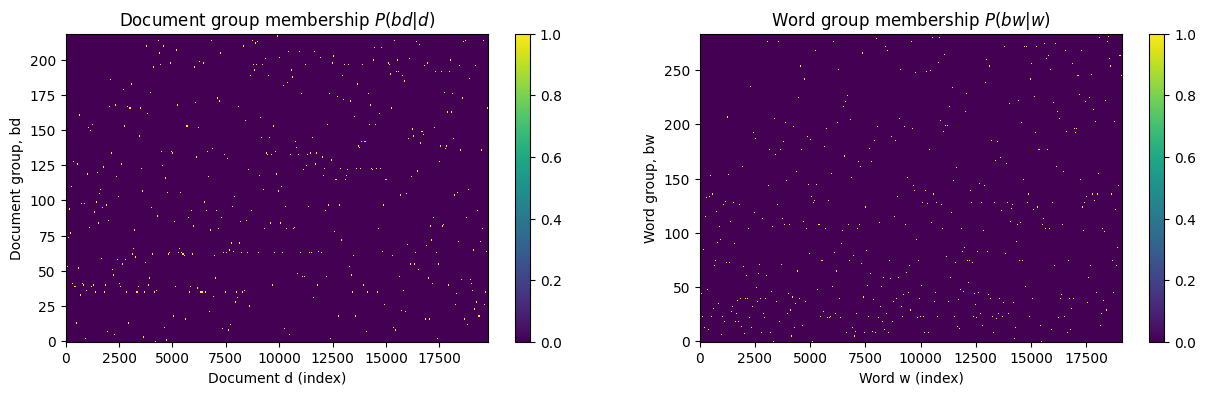

In [41]:
p_td_d,p_tw_w = model.group_membership(l=1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()